In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import librosa

In [2]:


def simple_chroma(x, N, H, Fs):
    # x:       input signal
    # N:       frame length
    # H:       hopsize
    # Fs:      sampling rate

    # Compute the STFT
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant')
    Y = np.abs(X) ** 2
    Y_comp = np.log(1 + 0.5 * Y)

    # Initialize the chroma matrix
    C = np.zeros((12, Y.shape[1]), dtype=Y.dtype)

    # Compute pitch-to-chroma mapping
    n = np.arange(1, Y.shape[0])  # Frequency bin indices
    pitches = np.round(12 * np.log2((Fs * n / N) / 440)) + 69  # Convert to MIDI note numbers
    chroma_mapping = pitches % 12
    chroma_mapping = np.insert(chroma_mapping, 0, -1)  # Ignore DC offset

    # Aggregate energy into chroma bins
    for k in range(12):
        C[k, :] = Y_comp[chroma_mapping == k, :].sum(axis=0)
    
    # Normalize chroma features
    C = normalize_chroma(C, 2, 0.0001)

    return C

def normalize_chroma(C, norm_p, threshold):
    f_norm = norm(C, norm_p, axis=0)
    C_norm = C.copy()
    C_norm[:, f_norm >= threshold] /= f_norm[f_norm >= threshold]
    return C_norm


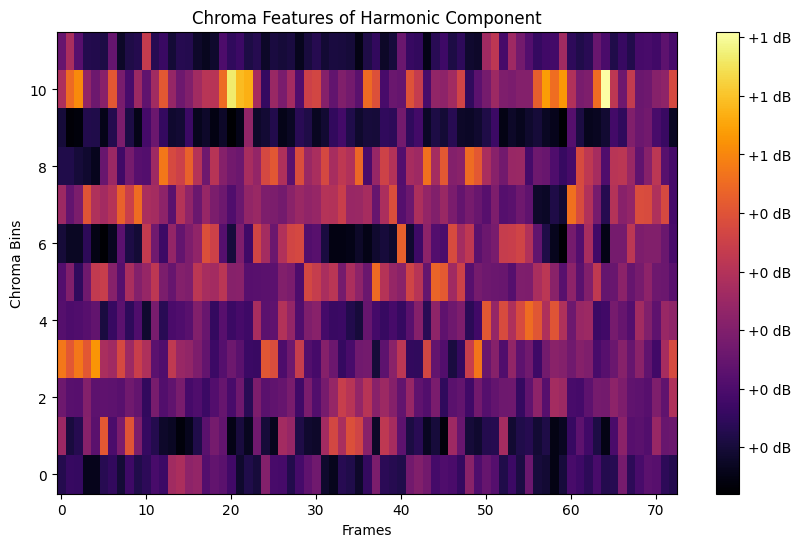

In [5]:
file_path = "audio_files/sitar_noisy3.wav"
x, Fs = librosa.load(file_path, sr=None)

N = 4410//3
H = 2205*3
w = "hann"

C_h = simple_chroma(x, N, H, Fs)

plt.figure(figsize=(10, 6))
plt.imshow(C_h, aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title("Chroma Features of Harmonic Component")
plt.xlabel("Frames")
plt.ylabel("Chroma Bins")
plt.show()